In [ ]:
import tensorflow as tf
import pandas as pd
!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")


# importing libraries and making checkpoint directory to save model weights for future use

In [2]:
# yfinance data length limits :

# Minute Data: 7 days
# 2 Minute Data: 60 days
# 5 Minute Data: 60 days
# 15 Minute Data: 60 days - 25 data points in one day 9:15 to 15:15
# 30 Minute Data: 60 days 
# Hourly Data: 730 days
# Daily/Weekly/Monthly: No _limit"

In [13]:
data = yf.download(tickers='^NSEI', period='60d', interval='5m')
df = pd.DataFrame()
df['Close'] = (data['Close'].diff())*10000/data['Close']
# df['Target'] = df['Close'].shift(-1)
print(df)
df['index'] = range(len(df))
df.set_index('index', inplace=True)


[*********************100%***********************]  1 of 1 completed
                               Close
Datetime                            
2023-03-31 09:15:00+05:30        NaN
2023-03-31 09:20:00+05:30  14.243386
2023-03-31 09:25:00+05:30  -0.579042
2023-03-31 09:30:00+05:30  -9.302725
2023-03-31 09:35:00+05:30   5.590055
...                              ...
2023-06-27 15:05:00+05:30   4.064103
2023-06-27 15:10:00+05:30   0.265607
2023-06-27 15:15:00+05:30  -4.065648
2023-06-27 15:20:00+05:30   0.025949
2023-06-27 15:25:00+05:30   0.744152

[4418 rows x 1 columns]


In [4]:
cdf = pd.DataFrame()
cdf = df.dropna()
cdf = cdf.astype(float)
cdf

,Close
index,
1,14.243386
2,-0.579042
3,-9.302725
4,5.590055
5,8.536744
...,...
4413,4.064103
4414,0.265607
4415,-4.065648


3.6490725644239075


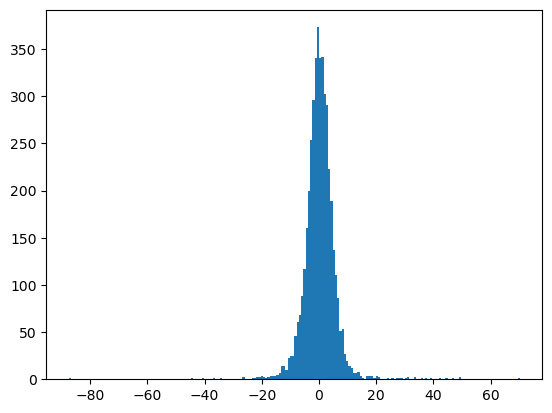

In [5]:
# visualizing the distribution of data

plt.hist(cdf['Close'], 200)
sum  = 0
for i in cdf['Close']:
    av = abs(i)
    sum = sum + av               
print(sum / len(cdf['Close']))

In [16]:
# making groups of data points of size equal to the time_steps of our model

sequence_length = 17


# Clip data into sequences of the desired length
num_sequences = cdf.shape[0] - sequence_length
# X_sequences = [cdf.loc[i:i+sequence_length, ['Close']] for i in range(num_sequences)]
X_sequences = [cdf.loc[i+1: i+sequence_length,['Close']] for i in range(num_sequences)]
y_sequences = [cdf.loc[i+2:i+sequence_length+1, ['Close']] for i in range(num_sequences)]

# Convert sequences to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)



In [17]:
y_sequences.shape

(4400, 17, 1)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(
      512,
      return_sequences=True,
      recurrent_initializer='he_normal',
      recurrent_activation='tanh',
      stateful=True,
    ),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(
      256,
      return_sequences=True,
      recurrent_initializer='he_normal',
      recurrent_activation='tanh',
      stateful=True,
    ),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1, activation='linear')
])

In [ ]:
num_epochs = 250 # Increase this to train longer
batch_size = 11  # Experiment between 1 and 64
learning_rate = 5e-4  # Experiment between 1e-5 and 1e-1
# Split the data into train and test sets (optional)

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.1, random_state=42)


model.build(input_shape=(batch_size,sequence_length,1))

optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(loss='mse', optimizer = optimizer)
# Train the model
model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

In [ ]:
model.save_weights(checkpoint_prefix)

In [ ]:
model.build(input_shape=(1,sequence_length,1))
# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

In [ ]:
input_data = [y_sequences[-1]]
input_data = np.array(input_data)
model.reset_states()

predictions = []
for i in range(sequence_length):
    input_timestep = input_data[:, i:i+1, :]
    prediction = model.predict(input_timestep)
    predictions.append(prediction)
    
# Convert the predictions to a numpy array
predictions = np.array(predictions)
predictions = np.array(predictions).reshape(-1, 1)


for i in range(sequence_length):
    print(y_sequences[-1, i, 0], " -> ", predictions[i,0])